### 환경구성

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm
from copy import deepcopy

import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")
#from collections import Counter
# mecab = Mecab()

In [ ]:
# GPU 사용
device = torch.device("cuda")

### data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Dialog-KoELECTRA/Dialog-KoELECTRA_light/dialog_electra/finetune/dialog_electra/finetune/data/hate-speech/train.tsv')
test = pd.read_csv('/content/drive/MyDrive/Dialog-KoELECTRA/Dialog-KoELECTRA_light/dialog_electra/finetune/dialog_electra/finetune/data/hate-speech/val.tsv')

In [ ]:
train

,sentence,target2
0,따돌림 당하는 반 친구를 도와줬는데 나를 배신했어. 너무 황당하고 배신감에 화가 나...,배신당한
1,물혹이 처음 발견되었을 때 얼마나 긴장했는지 몰라. 큰 이상이 아니어서 기뻐. 걱정...,기쁨
2,괜히 친구 뒷말을 했다가 다른 친구들과도 멀어져서 후회스러워. 친구 뒷담을 해서 후...,슬픔
3,내가 요즘 몸이 안 좋아서 병원에 다니고 있는데 자식들이 전화 한 통화 없어서 실망...,슬픔
4,위에서 아래를 내려다보며 살았었는데 이제는 턱도 없어. 무슨 의미인지 좀 더 구체적...,초조한
...,...,...
41299,아버지는 어째서 술만 드시면 행동이 난폭해지는 걸까? 욕설과 폭력은 이제 지긋지긋해...,초조한
41300,살이 쪄서 건강 검진받을 때마다 조마조마했는데 큰 병 없이 진단 결과가 나와서 참 ...,슬픔
41301,요새 취업이 과도한 경쟁으로 너무 힘들어져서 스트레스받아. 과도한 경쟁으로 취업이 ...,분노
41302,내일 발표하는 조별과제를 내가 마무리하는데 혹 실수를 하게 되지 않을까 조심스러워....,조심스러운


In [ ]:
d = dict()
idx = 0
for i in train['target2']:
    if i not in d:
        d[i] = idx
        idx += 1

for i, j in enumerate(train['target2']):
    train['target2'][i] = d[j]

for i, j in enumerate(test['target2']):
    test['target2'][i] = d[j]

In [ ]:
class NSMCDataset(Dataset):

  def __init__(self, df):
    self.dataset = df
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")  ## 토크나이저 확인하기!!#################
    print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    row = self.dataset.iloc[idx].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=256,
        pad_to_max_length=True,
        add_special_tokens=True
        )

    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [ ]:
train_dataset = NSMCDataset(train)
test_dataset = NSMCDataset(test)

                                                 sentence  target2
count                                               41304    41304
unique                                              41303       22
top     전부 언니는 공부를 잘한다고 언니한테만 잘해주고 나는 무시해. 그런 일이 있었군요....        2
freq                                                    2     8078
                                                 sentence  target2
count                                               10326    10326
unique                                              10326       22
top     나 내년 초에 드디어 결혼하게 됐어. 너무 기쁘다. 진심으로 축하드려요. 결혼하게 ...        2
freq                                                    1     2020


### 모델 학습하기

In [ ]:
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator", num_labels=22).to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [ ]:
epochs = 20
batch_size = 16

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-6)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
list_training_loss = []
list_test_loss = []
list_training_accuracy = []
list_test_accuracy = []

for i in range(epochs):
  total_loss = 0.0
  correct = 0
  total = 0
  batches = 0
  best_accuracy = 0

  model.train()

  for input_ids_batch, attention_masks_batch, y_batch in tqdm(train_loader):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch) ## loss로 cross entropy를 사용함
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    _, predicted = torch.max(y_pred, 1)
    correct += (predicted == y_batch).sum()
    total += len(y_batch)

    batches += 1
    if batches % 500 == 0:
      print("Batch Loss:", total_loss, "Accuracy:", correct.float() / total)

  # test 확인
  if True:
    model.eval()
    n_test = 0
    test_loss = 0
    correct_test = 0

    for input_ids, attention_masks, labels in tqdm(test_loader):
      outputs = model(input_ids.to(device), attention_mask=attention_masks.to(device), labels=labels.to(device))
      n_test += len(input_ids)
      del input_ids, attention_masks

      loss = outputs.loss  ##여기 loss는?
      idx_pred = torch.max(outputs.logits, 1)[1]
      test_loss += loss.data.cpu().numpy()
      #n_test += len(input_ids)
      correct_test += (idx_pred.cpu() == labels).sum()
      del labels

  list_training_loss.append(total_loss)
  list_test_loss.append(test_loss)
  list_training_accuracy.append(correct.float() / total)
  list_test_accuracy.append(correct_test.float() / n_test)
  print("epoch", i+1, "Train Loss:", total_loss, "Test Loss", test_loss, "Accuracy:", correct.float() / total, "test accuracy", correct_test.float() / n_test)

  if correct_test.float() / n_test > best_accuracy:
    best_acc_model = deepcopy(model) #model.state_dict())
    best_accuracy = correct_test.float() / n_test

  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 1402.924132823944 Accuracy: tensor(0.1863, device='cuda:0')
Batch Loss: 2750.2682518959045 Accuracy: tensor(0.1926, device='cuda:0')
Batch Loss: 4096.001241445541 Accuracy: tensor(0.1950, device='cuda:0')
Batch Loss: 5401.42126250267 Accuracy: tensor(0.2079, device='cuda:0')
Batch Loss: 6655.666678071022 Accuracy: tensor(0.2227, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 1 Train Loss: 6853.9576687812805 Test Loss 1548.6321829557419 Accuracy: tensor(0.2259, device='cuda:0') test accuracy tensor(0.3226)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 1179.7045736312866 Accuracy: tensor(0.3366, device='cuda:0')
Batch Loss: 2307.6742728948593 Accuracy: tensor(0.3557, device='cuda:0')
Batch Loss: 3427.2593120336533 Accuracy: tensor(0.3672, device='cuda:0')
Batch Loss: 4509.979510545731 Accuracy: tensor(0.3784, device='cuda:0')
Batch Loss: 5571.314935684204 Accuracy: tensor(0.3874, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 2 Train Loss: 5742.706152200699 Test Loss 1321.8286473751068 Accuracy: tensor(0.3885, device='cuda:0') test accuracy tensor(0.4451)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 1033.5555267333984 Accuracy: tensor(0.4349, device='cuda:0')
Batch Loss: 2033.7617542743683 Accuracy: tensor(0.4474, device='cuda:0')
Batch Loss: 3033.388251543045 Accuracy: tensor(0.4507, device='cuda:0')
Batch Loss: 4006.3650466799736 Accuracy: tensor(0.4563, device='cuda:0')
Batch Loss: 4962.021803200245 Accuracy: tensor(0.4625, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 3 Train Loss: 5116.513337433338 Test Loss 1228.280314564705 Accuracy: tensor(0.4639, device='cuda:0') test accuracy tensor(0.4895)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 931.3171599507332 Accuracy: tensor(0.4971, device='cuda:0')
Batch Loss: 1851.1516512036324 Accuracy: tensor(0.4987, device='cuda:0')
Batch Loss: 2776.857551217079 Accuracy: tensor(0.4980, device='cuda:0')
Batch Loss: 3680.5679535269737 Accuracy: tensor(0.5021, device='cuda:0')
Batch Loss: 4577.628421604633 Accuracy: tensor(0.5042, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 4 Train Loss: 4720.20061224699 Test Loss 1157.7956814169884 Accuracy: tensor(0.5055, device='cuda:0') test accuracy tensor(0.5141)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 880.7632021903992 Accuracy: tensor(0.5178, device='cuda:0')
Batch Loss: 1722.728712618351 Accuracy: tensor(0.5314, device='cuda:0')
Batch Loss: 2583.354935824871 Accuracy: tensor(0.5315, device='cuda:0')
Batch Loss: 3431.017085969448 Accuracy: tensor(0.5345, device='cuda:0')
Batch Loss: 4269.739425778389 Accuracy: tensor(0.5369, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 5 Train Loss: 4407.558024525642 Test Loss 1116.2347826957703 Accuracy: tensor(0.5370, device='cuda:0') test accuracy tensor(0.5359)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 836.5071659684181 Accuracy: tensor(0.5544, device='cuda:0')
Batch Loss: 1642.294885635376 Accuracy: tensor(0.5586, device='cuda:0')
Batch Loss: 2441.253515303135 Accuracy: tensor(0.5620, device='cuda:0')
Batch Loss: 3253.7288840711117 Accuracy: tensor(0.5624, device='cuda:0')
Batch Loss: 4039.0336769521236 Accuracy: tensor(0.5652, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 6 Train Loss: 4172.4964409172535 Test Loss 1064.649175465107 Accuracy: tensor(0.5652, device='cuda:0') test accuracy tensor(0.5524)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 773.671479344368 Accuracy: tensor(0.5816, device='cuda:0')
Batch Loss: 1546.507288634777 Accuracy: tensor(0.5824, device='cuda:0')
Batch Loss: 2315.51459223032 Accuracy: tensor(0.5839, device='cuda:0')
Batch Loss: 3083.2310000658035 Accuracy: tensor(0.5840, device='cuda:0')
Batch Loss: 3848.3078066706657 Accuracy: tensor(0.5852, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 7 Train Loss: 3969.204822063446 Test Loss 1061.3216306567192 Accuracy: tensor(0.5858, device='cuda:0') test accuracy tensor(0.5647)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 730.531890630722 Accuracy: tensor(0.5990, device='cuda:0')
Batch Loss: 1446.9146590828896 Accuracy: tensor(0.6068, device='cuda:0')
Batch Loss: 2194.8734627962112 Accuracy: tensor(0.6030, device='cuda:0')
Batch Loss: 2921.97087597847 Accuracy: tensor(0.6033, device='cuda:0')
Batch Loss: 3665.258223772049 Accuracy: tensor(0.6019, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 8 Train Loss: 3784.865486085415 Test Loss 1029.645540714264 Accuracy: tensor(0.6014, device='cuda:0') test accuracy tensor(0.5699)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 695.1718300282955 Accuracy: tensor(0.6176, device='cuda:0')
Batch Loss: 1398.9022914469242 Accuracy: tensor(0.6139, device='cuda:0')
Batch Loss: 2107.1484204232693 Accuracy: tensor(0.6140, device='cuda:0')
Batch Loss: 2804.6385999917984 Accuracy: tensor(0.6155, device='cuda:0')
Batch Loss: 3510.397119998932 Accuracy: tensor(0.6158, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 9 Train Loss: 3624.576254785061 Test Loss 1021.9919432103634 Accuracy: tensor(0.6162, device='cuda:0') test accuracy tensor(0.5745)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 667.1347247362137 Accuracy: tensor(0.6365, device='cuda:0')
Batch Loss: 1315.160258591175 Accuracy: tensor(0.6389, device='cuda:0')
Batch Loss: 1986.9526624381542 Accuracy: tensor(0.6373, device='cuda:0')
Batch Loss: 2661.5597891509533 Accuracy: tensor(0.6362, device='cuda:0')
Batch Loss: 3325.2331568598747 Accuracy: tensor(0.6366, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 10 Train Loss: 3438.642711997032 Test Loss 1005.3845136165619 Accuracy: tensor(0.6361, device='cuda:0') test accuracy tensor(0.5832)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 630.06672295928 Accuracy: tensor(0.6554, device='cuda:0')
Batch Loss: 1256.2767144143581 Accuracy: tensor(0.6568, device='cuda:0')
Batch Loss: 1890.1631130874157 Accuracy: tensor(0.6547, device='cuda:0')
Batch Loss: 2546.5822487175465 Accuracy: tensor(0.6520, device='cuda:0')
Batch Loss: 3171.7032237946987 Accuracy: tensor(0.6540, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 11 Train Loss: 3276.4412587583065 Test Loss 996.1043431758881 Accuracy: tensor(0.6536, device='cuda:0') test accuracy tensor(0.5898)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 602.236946105957 Accuracy: tensor(0.6719, device='cuda:0')
Batch Loss: 1206.3375748991966 Accuracy: tensor(0.6695, device='cuda:0')
Batch Loss: 1823.6339682638645 Accuracy: tensor(0.6666, device='cuda:0')
Batch Loss: 2416.6331342309713 Accuracy: tensor(0.6703, device='cuda:0')
Batch Loss: 3023.8443691283464 Accuracy: tensor(0.6694, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 12 Train Loss: 3117.9445455521345 Test Loss 1007.4600014984608 Accuracy: tensor(0.6698, device='cuda:0') test accuracy tensor(0.5878)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 565.0968758761883 Accuracy: tensor(0.6916, device='cuda:0')
Batch Loss: 1148.190865933895 Accuracy: tensor(0.6858, device='cuda:0')
Batch Loss: 1737.597662359476 Accuracy: tensor(0.6810, device='cuda:0')
Batch Loss: 2314.9623814821243 Accuracy: tensor(0.6817, device='cuda:0')
Batch Loss: 2885.6864660680294 Accuracy: tensor(0.6824, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 13 Train Loss: 2979.0070806741714 Test Loss 1012.730013281107 Accuracy: tensor(0.6830, device='cuda:0') test accuracy tensor(0.6010)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 538.0605549365282 Accuracy: tensor(0.7065, device='cuda:0')
Batch Loss: 1089.515261784196 Accuracy: tensor(0.6999, device='cuda:0')
Batch Loss: 1638.2848321348429 Accuracy: tensor(0.6994, device='cuda:0')
Batch Loss: 2184.85037201643 Accuracy: tensor(0.6983, device='cuda:0')
Batch Loss: 2755.9738232195377 Accuracy: tensor(0.6957, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 14 Train Loss: 2848.7212269604206 Test Loss 1023.5071226358414 Accuracy: tensor(0.6958, device='cuda:0') test accuracy tensor(0.5963)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 512.438182964921 Accuracy: tensor(0.7160, device='cuda:0')
Batch Loss: 1045.4823459237814 Accuracy: tensor(0.7117, device='cuda:0')
Batch Loss: 1570.4505342543125 Accuracy: tensor(0.7108, device='cuda:0')
Batch Loss: 2090.9158420860767 Accuracy: tensor(0.7098, device='cuda:0')
Batch Loss: 2625.8437992483377 Accuracy: tensor(0.7091, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 15 Train Loss: 2707.3526267260313 Test Loss 1049.2945216298103 Accuracy: tensor(0.7098, device='cuda:0') test accuracy tensor(0.5937)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 487.23593367636204 Accuracy: tensor(0.7281, device='cuda:0')
Batch Loss: 990.0075585395098 Accuracy: tensor(0.7239, device='cuda:0')
Batch Loss: 1486.6493382453918 Accuracy: tensor(0.7231, device='cuda:0')
Batch Loss: 1973.2739436775446 Accuracy: tensor(0.7251, device='cuda:0')
Batch Loss: 2477.690195515752 Accuracy: tensor(0.7246, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 16 Train Loss: 2561.91299970448 Test Loss 1061.616595864296 Accuracy: tensor(0.7244, device='cuda:0') test accuracy tensor(0.5836)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 464.43236353993416 Accuracy: tensor(0.7438, device='cuda:0')
Batch Loss: 919.8143420368433 Accuracy: tensor(0.7461, device='cuda:0')
Batch Loss: 1391.2539384961128 Accuracy: tensor(0.7428, device='cuda:0')
Batch Loss: 1858.0875337719917 Accuracy: tensor(0.7411, device='cuda:0')
Batch Loss: 2326.007677450776 Accuracy: tensor(0.7408, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 17 Train Loss: 2409.284230157733 Test Loss 1077.3818138241768 Accuracy: tensor(0.7401, device='cuda:0') test accuracy tensor(0.5845)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 439.01056882739067 Accuracy: tensor(0.7548, device='cuda:0')
Batch Loss: 874.9275285601616 Accuracy: tensor(0.7556, device='cuda:0')
Batch Loss: 1320.9999468624592 Accuracy: tensor(0.7535, device='cuda:0')
Batch Loss: 1756.1216040812433 Accuracy: tensor(0.7538, device='cuda:0')
Batch Loss: 2194.704889949411 Accuracy: tensor(0.7525, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 18 Train Loss: 2259.199758540839 Test Loss 1127.1445096433163 Accuracy: tensor(0.7533, device='cuda:0') test accuracy tensor(0.5768)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 403.57339146733284 Accuracy: tensor(0.7759, device='cuda:0')
Batch Loss: 805.9539479240775 Accuracy: tensor(0.7754, device='cuda:0')
Batch Loss: 1221.7752854600549 Accuracy: tensor(0.7727, device='cuda:0')
Batch Loss: 1636.239561893046 Accuracy: tensor(0.7712, device='cuda:0')
Batch Loss: 2061.1854774579406 Accuracy: tensor(0.7688, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 19 Train Loss: 2126.920107282698 Test Loss 1129.4642267227173 Accuracy: tensor(0.7687, device='cuda:0') test accuracy tensor(0.5851)


  0%|          | 0/2582 [00:00<?, ?it/s]

Batch Loss: 383.8816816210747 Accuracy: tensor(0.7801, device='cuda:0')
Batch Loss: 766.8469011187553 Accuracy: tensor(0.7826, device='cuda:0')
Batch Loss: 1158.866370305419 Accuracy: tensor(0.7820, device='cuda:0')
Batch Loss: 1543.9821250736713 Accuracy: tensor(0.7810, device='cuda:0')
Batch Loss: 1939.669528707862 Accuracy: tensor(0.7789, device='cuda:0')


  0%|          | 0/646 [00:00<?, ?it/s]

epoch 20 Train Loss: 2007.3706475049257 Test Loss 1153.1934868097305 Accuracy: tensor(0.7785, device='cuda:0') test accuracy tensor(0.5888)


In [ ]:
torch.save({'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/weights_electra.pt')

In [ ]:
torch.save(model, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/model_electra.pt')

In [ ]:
torch.save(best_acc_model, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/model_electra_best.pt')

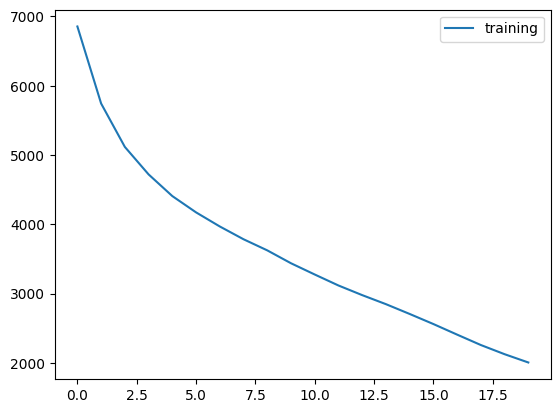

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
#plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

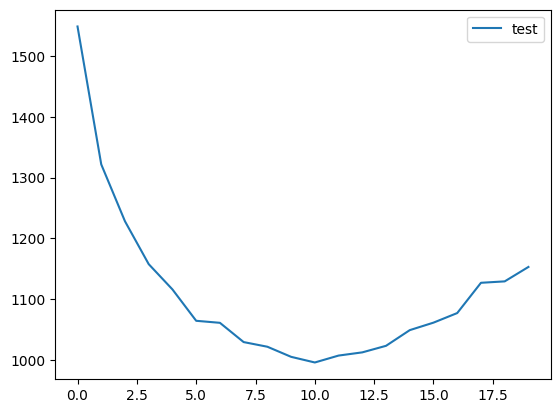

In [ ]:
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

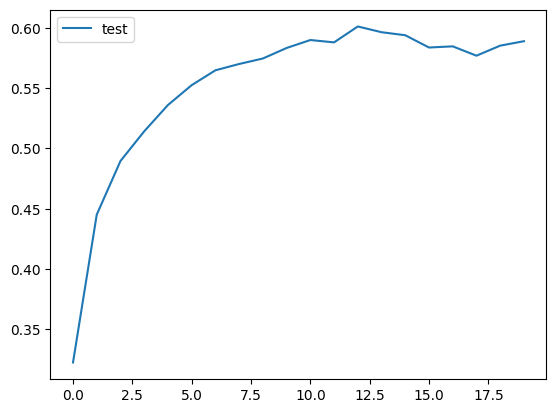

In [ ]:
plt.plot(list_test_accuracy, label='test')
plt.legend()
plt.show()

In [ ]:
torch.save({'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/weights_electra_ep25.pt')

In [ ]:
torch.save(model, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/model_electra_ep25.pt')

In [ ]:
torch.save(best_acc_model, '/content/drive/MyDrive/SentimentAnalysis/최종electra0625/model_electra_best.pt')

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/SentimentAnalysis/최종electra0625/weights_electra_ep25.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")
model = model.cpu()
model.eval()
from transformers import TextClassificationPipeline
sentiment_classifier = TextClassificationPipeline(tokenizer=tokenizer, model=model)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
test

,sentence,target2
0,교통사고를 당해 어쩔 수 없이 결혼식을 미루게 되었어. 그래서 지금 너무 슬퍼. 교...,16
1,직장에서 소심한 성격 때문에 문제가 있어서 힘들어. 어떤 문제 때문에 힘이 드시나요...,20
2,부모님은 날 너무 통제하셔서 너무 지쳐. 부모님의 통제가 마음을 지치게 하는군요. ...,37
3,나는 박 사장의 협박으로 백만 원을 빼앗겼어. 협박도 받고 돈을 빼앗겼다니 너무 두...,23
4,가장 친한 친구가 나랑 다른 진로 분야를 선택해서 너무 속상하고 외로워. 친한 친구...,26
...,...,...
11625,남편 회사 사람들이 유흥주점에 간 일로 난리가 났었는데 우리 남편만 가지 않았어. ...,22
11626,와이프가 갑자기 명품 핸드백을 사 달라는 거야. 당황하셨겠네요. 그래서 어떻게 대답...,39
11627,은퇴하기 전에 애들이 결혼을 다 했으면 좋겠어. 은퇴 전에 시키고 싶은 이유가 있으...,36
11628,학교 폭력 때문에 구역질 나. 학교 폭력 피해를 당하고 있나요? 응. 이제 날 좀 ...,55


In [ ]:
test_data = test.reset_index()

In [ ]:
for idx in tqdm(test_data.index) :
  review_list = [test_data.loc[idx,'sentence']]
  for review in review_list:
    pred = sentiment_classifier(review[:128])  ## 돌아가는 length 확인
    pred_label = pred[0]['label'][6:]
    pred_score = pred[0]['score']
    test_data.loc[idx,'pred'] = pred_label
    test_data.loc[idx,'score'] = pred_score
test_data

In [ ]:
test_data.to_csv('/content/drive/MyDrive/SentimentAnalysis/inference_sub_06211600.csv',index=False)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_data['target2'], test_data['pred']))